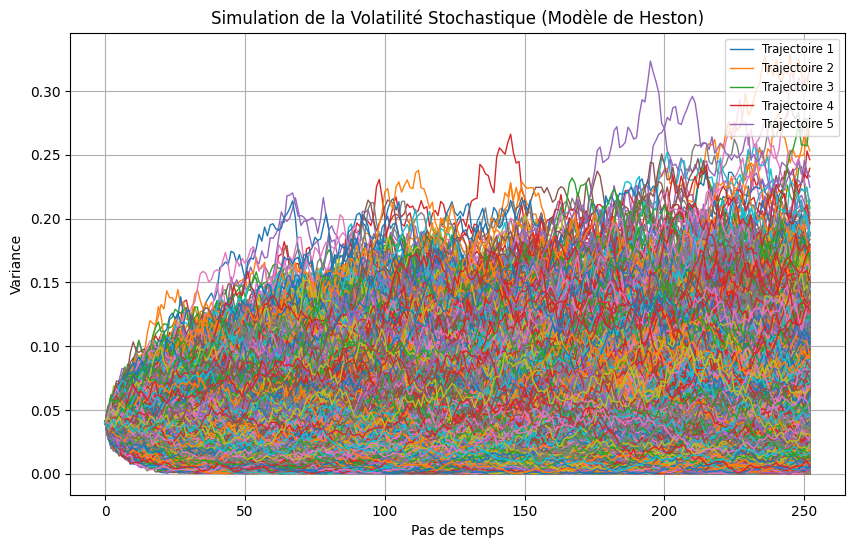

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_volatilite(v0, kappa, theta, sigma, T, N, M):
    """
    Simule M trajectoires de la variance (volatilité stochastique) selon le modèle de Heston.
    
    Paramètres:
      v0    : variance initiale
      kappa : vitesse de réversion vers la moyenne
      theta : variance à long terme (moyenne)
      sigma : volatilité de la variance (vol de vol)
      T     : durée totale de la simulation (en années)
      N     : nombre de pas de temps
      M     : nombre de trajectoires simulées
      
    Renvoie:
      v : tableau des trajectoires de la variance (dimensions M x (N+1))
    """
    dt = T / N  # intervalle de temps
    v = np.zeros((M, N+1))
    v[:, 0] = v0

    for t in range(1, N + 1):
        # Générer des incréments browniens pour chaque trajectoire
        W = np.random.normal(0, np.sqrt(dt), size=M)
        # Mise à jour de la variance par schéma d'Euler
        v[:, t] = np.abs(v[:, t-1] + kappa * (theta - v[:, t-1]) * dt + sigma * np.sqrt(v[:, t-1]) * W)
    
    return v

# Paramètres du modèle
v0 = 0.04      # Variance initiale (ex: pour une volatilité initiale de 20%, v0 = 0.2^2 = 0.04)
kappa = 1.5    # Vitesse de réversion de la variance
theta = 0.04   # Variance à long terme
sigma = 0.3    # Vol de vol
T = 1.0        # Durée de la simulation en années
N = 252        # Nombre de pas de temps (par exemple, nombre de jours de trading)
M = 10000         # Nombre de trajectoires simulées

# Simulation de la volatilité
v_paths = simulate_volatilite(v0, kappa, theta, sigma, T, N, M)

# Tracé des trajectoires de la variance
plt.figure(figsize=(10, 6))
for i in range(M):
    plt.plot(v_paths[i], lw=1, label=f'Trajectoire {i+1}' if i < 5 else None)
plt.title('Simulation de la Volatilité Stochastique (Modèle de Heston)')
plt.xlabel('Pas de temps')
plt.ylabel('Variance')
plt.grid(True)
plt.legend(loc='upper right', fontsize='small')
plt.show()


In [5]:
import numpy as np
from scipy.integrate import quad

# Characteristic function of log-spot under Heston (1993) model
def heston_char_func(u, tau, kappa, theta, sigma, rho, v0, r, q, S0):
    """
    Heston characteristic function phi(u; t): E[e^{iu ln S_t}]

    Parameters:
    u      : complex argument
    tau    : time to maturity T
    kappa  : mean reversion speed of variance
    theta  : long-term variance (mean level)
    sigma  : volatility of volatility
    rho    : correlation between Brownian motions
    v0     : initial variance
    r      : risk-free rate
    q      : dividend yield
    S0     : initial spot
    """
    # define parameters d and g
    alpha = -0.5 * (u**2 + 1j*u)
    beta = kappa - rho * sigma * 1j * u
    gamma = 0.5 * sigma**2

    # discriminant d
    d = np.sqrt(beta**2 - 4 * alpha * gamma)
    # g parameter
    g = (beta - d) / (beta + d)

    # C(t,u) and D(t,u)
    # C accumulates interest and drift terms
    C = (r - q) * 1j * u * tau + (kappa * theta / sigma**2) * \
        ((beta - d) * tau - 2 * np.log((1 - g * np.exp(-d * tau)) / (1 - g)))
    # D multiplies variance initial condition
    D = ((beta - d) / sigma**2) * ((1 - np.exp(-d * tau)) / (1 - g * np.exp(-d * tau)))

    # characteristic function
    phi = np.exp(C + D * v0 + 1j * u * np.log(S0 * np.exp(-q * tau)))
    return phi

# Vanilla call price under Heston via Fourier inversion
def heston_call_price(S0, K, tau, r, q,
                      kappa, theta, sigma, rho, v0):
    """
    Price a European call under Heston model using integrals for P1 and P2:

    C = S0 * exp(-q T) P1 - K * exp(-r T) P2
    Pj = 0.5 + (1/pi) * \int_0^\infty Re[e^{-i u ln K} phi(u - i*(j-1)) / (i u)] du
    """
    # Helper for P_j
    def P(j):
        integrand = lambda u: np.real(
            np.exp(-1j * u * np.log(K)) *
            heston_char_func(u - 1j * (j - 1), tau,
                              kappa, theta, sigma, rho, v0, r, q, S0)
            / (1j * u)
        )
        # integrate from 0 to infinity (approximate upper limit)
        integral, _ = quad(integrand, 1e-6, 200)
        return 0.5 + integral / np.pi

    # probabilities
    P1 = P(1)
    P2 = P(2)

    # call price
    call_price = S0 * np.exp(-q * tau) * P1 - K * np.exp(-r * tau) * P2
    return call_price


S0, K, r, q, tau = 100, 90, 0.05, 0.02, 1.0
kappa, theta, sigma, rho, v0 = 1.5, 0.04, 0.3, -0.7, 0.04

price = heston_call_price(S0, K, tau, r, q, kappa, theta, sigma, rho, v0)
print(f"Heston Call Price: {price:.4f}")  # ~ something


Heston Call Price: -2534.4820


# Part 1 : Characteristic Functions of the Models

# The Heston (1993) Model

## Stochastic Differential Equations

The Heston model describes asset price dynamics through a system of coupled stochastic differential equations. Under the real-world measure $\mathbb{P}$, both the asset price and its variance follow Brownian motion processes:

**Asset Price Process:**
$$dS_t = \mu S_t dt + \sqrt{v_t}S_t dW^\mathbb{P}_{S,t}$$

**Variance Process:**
$$dv_t = \kappa(\theta - v_t)dt + \sigma \sqrt{v_t} dW^\mathbb{P}_{v,t}$$

### Model Parameters

| Parameter | Description |
|-----------|-------------|
| $\sigma$ | Volatility of volatility |
| $\theta$ | Long-term variance (mean reversion level) |
| $\kappa$ | Mean reversion speed |
| $dW^\mathbb{P}_{S,t}$ | Brownian motion driving asset price |
| $dW^\mathbb{P}_{v,t}$ | Brownian motion driving variance |
| $\rho$ | Correlation between the two Brownian motions |

## Risk-Neutral Dynamics

Under the risk-neutral measure $\mathbb{Q}$, used for option pricing:

**Risk-Neutral Asset Price Process:**
$$dS_t = r S_t dt + \sqrt{v_t}S_t dW^\mathbb{Q}_{S,t}$$

**Risk-Neutral Variance Process:**
$$dv_t = \kappa^\mathbb{Q}(\theta^\mathbb{Q} - v_t)dt + \sigma^\mathbb{Q} \sqrt{v_t} dW^\mathbb{Q}_{v,t}$$

Where:
- $r$ is the risk-free interest rate
- $\kappa^\mathbb{Q}$, $\theta^\mathbb{Q}$, and $\sigma^\mathbb{Q}$ are the risk-neutral parameters

In [55]:
# Parameters
# simulation dependent
S0 = 100.0             # asset price
T = 1.0                # time in years
r = 0.02               # risk-free rate
N = 252                # number of time steps in simulation
M = 10000               # number of simulations

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility

theta, v0


(0.04000000000000001, 0.0625)

In [56]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations

    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    #Sum the prices at the 253rd day for each simulation and divide by the number of simulations
    Price = np.sum(S[-1], axis=0) / M

    return S, v, Price

In [57]:
S_p,v_p,price = heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M)
print(price)

102.02993293011384


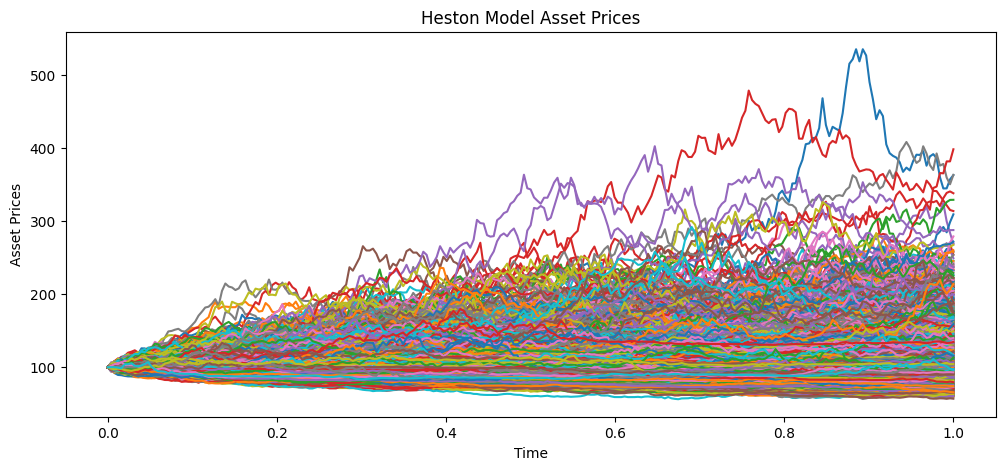

In [58]:
fig, ax1  = plt.subplots(1, 1, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time,S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')
plt.show()

## The Heston- Bates Model

In [64]:
import numpy as np
from scipy.integrate import quad

def heston_bates_cf(u, params, S0, r, tau):
    """
    Characteristic function of log-price under Heston–Bates
    """
    kappa, theta = params['kappa'], params['theta']
    sigma, rho   = params['sigma'], params['rho']
    v0           = params['v0']
    lam, muj     = params['lambda'], params['mu_j']
    sigj         = params['sigma_j']
    i = 1j

    # Heston part
    a = kappa * theta
    b = kappa - rho * sigma * i * u
    d = np.sqrt((rho * sigma * i * u - b)**2 + sigma**2 * (i*u + u**2))
    g = (b - d) / (b + d)
    C = (r * i * u * tau
         + (a / sigma**2) * ((b - d)*tau - 2.0*np.log((1 - g*np.exp(-d*tau)) / (1 - g))))
    D = ((b - d) / sigma**2) * ((1 - np.exp(-d*tau)) / (1 - g*np.exp(-d*tau)))

    # Jump part with martingale correction
    jump_comp = lam * tau * (
        np.exp(i*u*muj - 0.5*u**2*sigj**2)
        - 1
        - i * u * muj
    )

    # Total characteristic function
    return np.exp(C + D*v0 + i*u*np.log(S0) + jump_comp)

def P_integrand(u, params, S0, r, tau, K, j):
    """
    Integrand for P_j, with shift j=1,2
    """
    i = 1j
    u_shift = u - i*(j-1)
    phi_shift = heston_bates_cf(u_shift, params, S0, r, tau)
    denom = i*u * heston_bates_cf(-i*(j-1), params, S0, r, tau)
    return np.real(np.exp(-i*u*np.log(K)) * phi_shift / denom)

def P_j(j, params, S0, r, tau, K, cutoff=500):
    """
    Compute P_j = 1/2 + (1/pi)*Integral_0^cutoff integrand
    """
    integrand = lambda u: P_integrand(u, params, S0, r, tau, K, j)
    integral_val = quad(integrand, 0.0, cutoff, limit=300)[0]
    return 0.5 + integral_val/np.pi

def heston_bates_call_price(params, S0, K, r, tau):
    P1 = P_j(1, params, S0, r, tau, K)
    P2 = P_j(2, params, S0, r, tau, K)
    call_price = S0 * P1 - K * np.exp(-r * tau) * P2
    return P1, P2, call_price

# Model parameters
params = {
    'kappa': 2.0,      # Mean reversion speed
    'theta': 0.05,     # Long-run variance
    'sigma': 0.3,      # Volatility of variance
    'rho':   -0.7,     # Correlation
    'v0':    0.05,     # Initial variance
    'lambda':0.1,      # Jump intensity
    'mu_j': -0.05,     # Mean jump size
    'sigma_j':0.2      # Jump volatility
}

S0 = 100.0   # Spot price
K  = 100.0   # Strike price
r  = 0.03    # Risk-free rate
tau= 1.0     # Time to maturity (years)

P1, P2, price = heston_bates_call_price(params, S0, K, r, tau)
print(f"P1 = {P1:.6f}, P2 = {P2:.6f}")
print(f"Heston–Bates call price: {price:.4f}")


P1 = 0.010461, P2 = 0.015169
Heston–Bates call price: -0.4259


In [65]:
import numpy as np
from scipy.integrate import quad

def heston_bates_cf(u, params, S0, r, tau):
    """
    Characteristic function of log‑price under le modèle Heston–Bates
    avec compensation des sauts et ajustement du drift de volatilité.
    """
    # Extraction des paramètres “réels”
    alpha, beta      = params['alpha'], params['beta']
    xi               = params['xi']         # cov(dV, dJ/J) / V
    sigma_v, rho     = params['sigma_v'], params['rho']
    v0               = params['v0']
    lambda0          = params['lambda']
    muj, sigma_j     = params['mu_j'], params['sigma_j']
    
    # 1) Ajustement du processus de volatilité :
    beta_star = beta - xi
    kappa     = beta_star
    theta     = alpha / beta_star

    # 2) Compensation des sauts sous Q :
    #    E[e^Y]   = exp(muj + ½ sigma_j^2)
    #    k_star   = E[e^Y] – 1
    #    lambda_star = lambda0 · E[e^Y]
    Ej    = np.exp(muj + 0.5 * sigma_j**2)
    k_star    = Ej - 1.0
    lambda_star = lambda0 * Ej

    # 3) On remplace r → r_adj = r – lambda_star * k_star pour le drift de S
    r_adj = r - lambda_star * k_star

    i = 1j
    a = kappa * theta
    b = kappa - rho * sigma_v * i * u
    d = np.sqrt((rho * sigma_v * i * u - b)**2 + sigma_v**2 * (i*u + u**2))
    g = (b - d) / (b + d)

    # Partie “Heston”
    C = (r_adj * i * u * tau
         + (a / sigma_v**2)
           * ((b - d) * tau
              - 2.0 * np.log((1 - g * np.exp(-d * tau)) / (1 - g))))
    D = ((b - d) / sigma_v**2) * ((1 - np.exp(-d * tau))
                                 / (1 - g * np.exp(-d * tau)))

    # Partie “sauts” avec correction de martingale
    # φ_j(u) = E[e^{i u Y}] = exp(i u muj – ½ u^2 sigma_j^2)
    jump_comp = lambda_star * tau * (
        np.exp(i*u*muj - 0.5*u**2*sigma_j**2)
        - 1
        - i*u*muj
    )

    # CF totale
    return np.exp(C + D*v0 + i*u*np.log(S0) + jump_comp)


def P_j(j, params, S0, r, tau, K, cutoff=500):
    """Calcul de P1 ou P2 via quadrature sur [0, cutoff]."""
    def integrand(u):
        i = 1j
        u_shift = u - i*(j-1)
        num = np.exp(-i*u*np.log(K)) * heston_bates_cf(u_shift, params, S0, r, tau)
        den = i*u * heston_bates_cf(-i*(j-1), params, S0, r, tau)
        return np.real(num/den)

    I = quad(integrand, 0.0, cutoff, limit=300)[0]
    return 0.5 + I/np.pi


def heston_bates_call_price(params, S0, K, r, tau):
    P1 = P_j(1, params, S0, r, tau, K)
    P2 = P_j(2, params, S0, r, tau, K)
    price = S0 * P1 - K * np.exp(-r * tau) * P2
    return P1, P2, price



params = {
    'alpha'   : 0.05,    # drift du processus v avant MR
    'beta'    : 2.0,     # mean‑reversion speed avant compensation
    'xi'      : 0.1,     # cov(dV, dJ/J) / V
    'sigma_v' : 0.3,     # vol de la vol
    'rho'     : -0.7,    # corrélation
    'v0'      : 0.05,    # var initiale
    'lambda'  : 0.1,     # intensité de Poisson
    'mu_j'    : -0.05,   # mean(log jump)
    'sigma_j' : 0.2      # vol(log jump)
}
S0, K, r, tau = 100.0, 100.0, 0.03, 1.0

P1, P2, price = heston_bates_call_price(params, S0, K, r, tau)
print(f"P1 = {P1:.6f}, P2 = {P2:.6f}")
print(f"Heston–Bates call price: {price:.6f}")


P1 = 0.014299, P2 = 0.019914
Heston–Bates call price: -0.502648
